
# PC LAB 3 - Group 4 - Sofia Michael **Yash** Omar


Time spent: 15-20 hours

Difficulty: 7/10

## Download Libraries and download the data

In [2]:
!pip install contractions
!pip install emoji
!pip install ekphrasis

import sys
import math
import pandas as pd
import re
import emoji
import nltk
import contractions
import torch

nltk.download('punkt')
nltk.download('stopwords')
# from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords as sw
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
import requests
from pprint import pprint
import numpy as np
from nltk.stem import PorterStemmer


import pandas as pd
from bs4 import BeautifulSoup
import yfinance as yf
import requests
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from ekphrasis.classes.segmenter import Segmenter
import spacy
from tqdm import tqdm
from wordcloud import WordCloud
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline, pipeline
import torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 19.7 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/michaelladaa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelladaa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading yfinance data and merging datasets

This section of the notebook is to merge the tweets dataset with the appropriate stock data from yfinance. We then create two variables, pct_before and pct_after, which represent the percentage change in stock price one day before and one day after the tweet was posted.

In [ ]:
tweets = pd.read_csv("tweet_data.csv")

In [ ]:
tweets = tweets[tweets["symbol"].map(tweets["symbol"].value_counts()) > 50]

In [ ]:
tweets = tweets[tweets['symbol'] != 'VIX']

In [ ]:
tickers = tweets["symbol"].unique().tolist()

In [ ]:
tickers = [t.replace(".", "-").replace("FB", "META") for t in tickers]

In [ ]:
tweets['symbol'] = tweets['symbol'].replace(r"\.", "-", regex=True).replace("FB", "META")

In [ ]:
tweets['symbol'].value_counts()

In [ ]:
data = yf.download(tickers, start="2009-07-01", end="2020-07-28")

In [ ]:
tweets.head()

In [ ]:
tweets['datetime'] = pd.to_datetime(tweets['datetime']).dt.tz_convert('US/Eastern')
tweets["date"] = pd.to_datetime(tweets["datetime"]).dt.date
tweets['time'] = pd.to_datetime(tweets['datetime']).dt.time
tweets.head()

In [ ]:
tweets['weekday'] = pd.to_datetime(tweets['date']).dt.weekday
tweets['weekday'] = tweets['weekday'].map({0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'})

In [ ]:
tweets['pct_before'] = np.nan
tweets['pct_after'] = np.nan

In [ ]:
data_open = data['Open']
data_close = data['Close']

In [ ]:
data_open.head()

In [ ]:
data_close.head()

In [ ]:
pct_change = (data_close - data_open) / data_open
pct_change.head()

In [ ]:
# First, filter out rows with NaT values
valid_time_mask = tweets['time'].notna()
tweets_valid = tweets[valid_time_mask].copy()

# Define market close time
market_close = pd.to_datetime('16:00:00').time()

# Create masks for different conditions
before_close = tweets_valid['time'] < market_close
after_close = tweets_valid['time'] >= market_close

# Weekend masks
is_saturday = tweets_valid['weekday'] == 'Sat'
is_sunday = tweets_valid['weekday'] == 'Sun'
is_friday = tweets_valid['weekday'] == 'Fri'
is_monday = tweets_valid['weekday'] == 'Mon'
is_weekday = ~(is_saturday | is_sunday | is_friday)
is_weekday_2 = ~(is_saturday | is_sunday | is_friday | is_monday)

# Helper function to safely get stock data
def get_stock_data(symbols, dates, pct_change_dict):
    """Safely retrieve stock data for given symbols and dates"""
    result = pd.Series(index=symbols.index, dtype=float)

    for idx in symbols.index:
        symbol = symbols.loc[idx]
        date = dates.loc[idx]
        try:
            if symbol in pct_change_dict:
                result.loc[idx] = pct_change_dict[symbol].loc[pd.to_datetime(date)]
        except (KeyError, TypeError):
            result.loc[idx] = np.nan

    return result

# Process each condition separately
# 1. Before market close - Saturday tweets
mask1 = before_close & is_saturday
if mask1.sum() > 0:
    subset = tweets_valid[mask1]
    tweets.loc[subset.index, 'pct_before'] = get_stock_data(
        subset['symbol'],
        subset['date'] - pd.Timedelta(days=1),
        pct_change
    )
    tweets.loc[subset.index, 'pct_after'] = get_stock_data(
        subset['symbol'],
        subset['date'] + pd.Timedelta(days=2),
        pct_change
    )

# 2. Before market close - Sunday tweets
mask2 = before_close & is_sunday
if mask2.sum() > 0:
    subset = tweets_valid[mask2]
    tweets.loc[subset.index, 'pct_before'] = get_stock_data(
        subset['symbol'],
        subset['date'] - pd.Timedelta(days=2),
        pct_change
    )
    tweets.loc[subset.index, 'pct_after'] = get_stock_data(
        subset['symbol'],
        subset['date'] + pd.Timedelta(days=1),
        pct_change
    )

# 3. Before market close - Weekdays (Mon-Thu)
mask3 = before_close & is_weekday_2
if mask3.sum() > 0:
    subset = tweets_valid[mask3]
    tweets.loc[subset.index, 'pct_before'] = get_stock_data(
        subset['symbol'],
        subset['date'] - pd.Timedelta(days=1),
        pct_change
    )
    tweets.loc[subset.index, 'pct_after'] = get_stock_data(
        subset['symbol'],
        subset['date'],
        pct_change
    )

# 4. After market close - Friday tweets
mask4 = after_close & is_friday
if mask4.sum() > 0:
    subset = tweets_valid[mask4]
    tweets.loc[subset.index, 'pct_before'] = get_stock_data(
        subset['symbol'],
        subset['date'],
        pct_change
    )
    tweets.loc[subset.index, 'pct_after'] = get_stock_data(
        subset['symbol'],
        subset['date'] + pd.Timedelta(days=3),
        pct_change
    )

# 4. Before market close - Friday tweets
mask5 = before_close & is_friday
if mask5.sum() > 0:
    subset = tweets_valid[mask5]
    tweets.loc[subset.index, 'pct_before'] = get_stock_data(
        subset['symbol'],
        subset['date'] - pd.Timedelta(days=1),
        pct_change
    )
    tweets.loc[subset.index, 'pct_after'] = get_stock_data(
        subset['symbol'],
        subset['date'],
        pct_change
    )

# 5. After market close - Saturday tweets
mask6 = after_close & is_saturday
if mask6.sum() > 0:
    subset = tweets_valid[mask6]
    tweets.loc[subset.index, 'pct_before'] = get_stock_data(
        subset['symbol'],
        subset['date'] - pd.Timedelta(days=1),
        pct_change     )
    tweets.loc[subset.index, 'pct_after'] = get_stock_data(
        subset['symbol'],
        subset['date'] + pd.Timedelta(days=2),
        pct_change
    )

# 6. After market close - Sunday tweets
mask7 = after_close & is_sunday
if mask7.sum() > 0:
    subset = tweets_valid[mask7]
    tweets.loc[subset.index, 'pct_before'] = get_stock_data(
        subset['symbol'],
        subset['date'] - pd.Timedelta(days=2),
        pct_change
    )
    tweets.loc[subset.index, 'pct_after'] = get_stock_data(
        subset['symbol'],
        subset['date'] + pd.Timedelta(days=1),
        pct_change
    )

# 7. After market close - Weekdays (Mon-Thu)
mask8 = after_close & is_weekday
if mask8.sum() > 0:
    subset = tweets_valid[mask8]
    tweets.loc[subset.index, 'pct_before'] = get_stock_data(
        subset['symbol'],
        subset['date'],
        pct_change
    )
    tweets.loc[subset.index, 'pct_after'] = get_stock_data(
        subset['symbol'],
        subset['date'] + pd.Timedelta(days=1),
        pct_change
    )

# 2. Before market close - Monday tweets
mask9 = before_close & is_monday
if mask9.sum() > 0:
    subset = tweets_valid[mask9]
    tweets.loc[subset.index, 'pct_before'] = get_stock_data(
        subset['symbol'],
        subset['date'] - pd.Timedelta(days=3),
        pct_change
    )
    tweets.loc[subset.index, 'pct_after'] = get_stock_data(
        subset['symbol'],
        subset['date'],
        pct_change
    )

print("Processing complete!")
print(f"Rows with valid pct_before: {tweets['pct_before'].notna().sum()}")
print(f"Rows with valid pct_after: {tweets['pct_after'].notna().sum()}")

In [ ]:
# tweets.to_csv('tweets_data_pct.csv', index=False)

In [ ]:
tweets = pd.read_csv("/tweets_data_pct.csv")

In [18]:
tweets

,symbol,message,datetime,user,message_id,date,time,weekday,pct_before,pct_after
0,AAPL,@dustin I&amp;#39;m long $aapl or at least unt...,2009-07-10 17:47:36-04:00,2.0,407487.0,2009-07-10,17:47:36,Fri,0.015989,0.020066
1,AAPL,$AAPL liver,2009-07-11 01:36:05-04:00,5.0,407689.0,2009-07-11,01:36:05,Sat,0.015989,0.020066
2,AAPL,RT @howardlindzon $AAPL liver,2009-07-11 01:38:01-04:00,5.0,407691.0,2009-07-11,01:38:01,Sat,0.015989,0.020066
3,AAPL,RT @howardlindzon RT @howardlindzon $AAPL liver,2009-07-11 01:38:16-04:00,5.0,407693.0,2009-07-11,01:38:16,Sat,0.015989,0.020066
4,AAPL,Apple Touchscreen Netbook to Launch in October...,2009-07-13 13:44:22-04:00,24.0,410448.0,2009-07-13,13:44:22,Mon,0.015989,0.020066
...,...,...,...,...,...,...,...,...,...,...
6292675,QQQ,$SPY $SPX $QQQ $DIA $IWM US market is just a ...,2020-07-23 21:02:07-04:00,537943.0,230466029.0,2020-07-23,21:02:07,Thu,-0.024574,0.005983
6292676,QQQ,"$SPY $SPX $QQQ $DIA $IWM The more infections,...",2020-07-23 21:06:59-04:00,537943.0,230466881.0,2020-07-23,21:06:59,Thu,-0.024574,0.005983
6292677,QQQ,$SPY $AAPL $AMZN $QQQ Bears didn’t see this co...,2020-07-23 21:07:35-04:00,3380046.0,230466980.0,2020-07-23,21:07:35,Thu,-0.024574,0.005983
6292678,QQQ,"$SPY $QQQ btd, pamp it, brrrrrrrrrrrrrrrrrrt",2020-07-23 21:12:33-04:00,1869377.0,230467789.0,2020-07-23,21:12:33,Thu,-0.024574,0.005983


As already discussed in class we found our own dataset on https://www.mdpi.com/2571-5577/4/1/13.

Different to the dataset given in the class we have many more datapoints (in this case 6.4 Million tweets). Another difference is that we have timestamps for each tweet and a column, which indicates the stock that the tweet is about. The aim of adding the timestamps is to implement Granger Causality, to see if tweets cause a differnce in stock returns or if stock returns cause a difference in tweets. Lastly, our dataset does not contain any form of sentiment score. Therefore, in task 3, we aim to compare two different methods of sentiment scoring, in line with what was discussed in the associated paper.

## TASK 1 - Basic Manipulation & Descriptive Statistics

In [ ]:
tweets.head()

,symbol,message,datetime,user,message_id,date,time,weekday,pct_before,pct_after
0,AAPL,@dustin I&amp;#39;m long $aapl or at least unt...,2009-07-10 17:47:36-04:00,2.0,407487.0,2009-07-10,17:47:36,Fri,0.015989,0.020066
1,AAPL,$AAPL liver,2009-07-11 01:36:05-04:00,5.0,407689.0,2009-07-11,01:36:05,Sat,0.015989,0.020066
2,AAPL,RT @howardlindzon $AAPL liver,2009-07-11 01:38:01-04:00,5.0,407691.0,2009-07-11,01:38:01,Sat,0.015989,0.020066
3,AAPL,RT @howardlindzon RT @howardlindzon $AAPL liver,2009-07-11 01:38:16-04:00,5.0,407693.0,2009-07-11,01:38:16,Sat,0.015989,0.020066
4,AAPL,Apple Touchscreen Netbook to Launch in October...,2009-07-13 13:44:22-04:00,24.0,410448.0,2009-07-13,13:44:22,Mon,0.015989,0.020066


### Count of Tweets

In [ ]:
print(f"The number of tweets in this dataset is: {tweets['message'].count()}")

The number of tweets in this dataset is: 6292680


### Word Count per Tweet

In [ ]:
tweets['word_count'] = tweets['message'].apply(lambda x: len(str(x).split()))

In [ ]:
print(f"The average number of words per tweet is: {tweets['word_count'].mean()}")

The average number of words per tweet is: 15.726429279734548


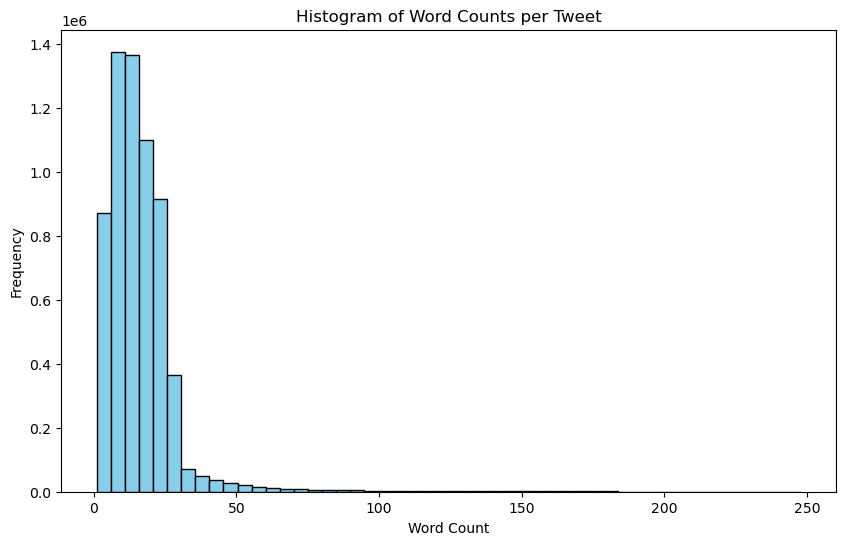

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(tweets['word_count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Counts per Tweet')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

## TASK 2 - Cleaning & Vizualisation

For preprocessing, we use the same steps taken in preprocessing in the paper, which can be found on the associated github repo. 

We remove stopwords, URLs, mentions, hashtags, repeated letters, contractions, and emojis. We also convert all text to lowercase, perform tokenization, and remove retweets. 

In [19]:
tweets['message'] = tweets['message'].fillna('0')

In [20]:
tweets['message'] = tweets['message'].str.lower() # Lowercase the text
messages = tweets['message'].tolist()

In [21]:
# Function to remove stopwords
def remove_stopwords(msg):
    filtered_sentence = [w for w in msg_tokens if not w in stop_words]
    return filtered_sentence

# Function to remove punctuations, URLs, Mentions, Hashtags and _ from emojis
def remove_punctuation_re(x):
    x = ' '.join(re.sub("https?://\S+","",x).split())     # Removing URLs
    x = ' '.join(re.sub("^@\S+|\s@\S+","",x).split())     # Removing Mentions
    x = ' '.join(re.sub(r'[^\w\s]'," ",x).split())        # Removes Hashtags
    x = ' '.join(re.sub(r'_'," ",x).split())              # Removing _ from emojis text
    return x

# Function to replace repeating letter
def rpt_replace(match):
    return match.group(1)+match.group(1)

# Function to substitute original word with replaced word, if any
def processRepeatings(data):
    re_t= re.sub(message_rpt, rpt_replace, data )
    return re_t

<>:8: SyntaxWarning: invalid escape sequence '\S'
<>:9: SyntaxWarning: invalid escape sequence '\S'
<>:8: SyntaxWarning: invalid escape sequence '\S'
<>:9: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-4004094847.py:8: SyntaxWarning: invalid escape sequence '\S'
  x = ' '.join(re.sub("https?://\S+","",x).split())     # Removing URLs
/tmp/ipython-input-4004094847.py:9: SyntaxWarning: invalid escape sequence '\S'
  x = ' '.join(re.sub("^@\S+|\s@\S+","",x).split())     # Removing Mentions


In [22]:
# Download stopwords
stop_words = sw.words("english")

# Create tokenizer and detokenizer
tweet_tokenizer = TweetTokenizer()
detokenizer = TreebankWordDetokenizer()

# For repeating characters in words
message_rpt = re.compile(r"(.)\1{2,}", re.IGNORECASE)

# Segmenter using the word statistics from Twitter
seg_tw = Segmenter(corpus="twitter")

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt


/usr/local/lib/python3.12/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [23]:
message_p = []
count = 0

for msg in messages:
    print(count)
    count += 1

    if msg == '0': # NaN replaced by '0'
      message_p.append('-1')

    else:
      # remove emojis
      msg = emoji.demojize(msg)

      # fix contractions
      msg = contractions.fix(msg)

      # remove punctuations
      msg = remove_punctuation_re(msg)

      # tokenize
      msg_tokens = tweet_tokenizer.tokenize(msg)

      # For compressing elongated words using Word segmenter
      message_seg = []
      for w in msg_tokens:
        if len(w) >= 300: # truncate word to 100 characters if it's original length is more than 300
          w = w[:100]
          print(w)
        message_seg.append(seg_tw.segment(w))

      # remove stopwords
      msg = remove_stopwords(message_seg)

      if 'rt' in msg:
        # remove retweets
        message_p.append('-1')
      else:
        # detokenize
        msg = detokenizer.detokenize(msg)

        # removing repeating characters like hurrrryyyyyy-- worrks on tokenized list
        msg = processRepeatings(msg)

        message_p.append(msg)

Streaming output truncated to the last 5000 lines.
6287680
6287681
6287682
6287683
6287684
6287685
6287686
6287687
6287688
6287689
6287690
6287691
6287692
6287693
6287694
6287695
6287696
6287697
6287698
6287699
6287700
6287701
6287702
6287703
6287704
6287705
6287706
6287707
6287708
6287709
6287710
6287711
6287712
6287713
6287714
6287715
6287716
6287717
6287718
6287719
6287720
6287721
6287722
6287723
6287724
6287725
6287726
6287727
6287728
6287729
6287730
6287731
6287732
6287733
6287734
6287735
6287736
6287737
6287738
6287739
6287740
6287741
6287742
6287743
6287744
6287745
6287746
6287747
6287748
6287749
6287750
6287751
6287752
6287753
6287754
6287755
6287756
6287757
6287758
6287759
6287760
6287761
6287762
6287763
6287764
6287765
6287766
6287767
6287768
6287769
6287770
6287771
6287772
6287773
6287774
6287775
6287776
6287777
6287778
6287779
6287780
6287781
6287782
6287783
6287784
6287785
6287786
6287787
6287788
6287789
6287790
6287791
6287792
6287793
6287794
6287795
6287796
6287797
62877

In [24]:
tweets['cleaned_message'] = message_p
tweets.head()

,symbol,message,datetime,user,message_id,date,time,weekday,pct_before,pct_after,cleaned_message
0,AAPL,@dustin i&amp;#39;m long $aapl or at least unt...,2009-07-10 17:47:36-04:00,2.0,407487.0,2009-07-10,17:47:36,Fri,0.015989,0.020066,amp 39 long aapl least goog os next year
1,AAPL,$aapl liver,2009-07-11 01:36:05-04:00,5.0,407689.0,2009-07-11,01:36:05,Sat,0.015989,0.020066,aapl liver
2,AAPL,rt @howardlindzon $aapl liver,2009-07-11 01:38:01-04:00,5.0,407691.0,2009-07-11,01:38:01,Sat,0.015989,0.020066,-1
3,AAPL,rt @howardlindzon rt @howardlindzon $aapl liver,2009-07-11 01:38:16-04:00,5.0,407693.0,2009-07-11,01:38:16,Sat,0.015989,0.020066,-1
4,AAPL,apple touchscreen netbook to launch in october...,2009-07-13 13:44:22-04:00,24.0,410448.0,2009-07-13,13:44:22,Mon,0.015989,0.020066,apple touchscreen netbook launch october 800 e...


In [27]:
tweets.drop(tweets[tweets['cleaned_message'] == '-1'].index, inplace = True)

In [28]:
tweets.to_csv("preprocessed_tweets_v2.csv", index=False)

In [29]:
tweets

,symbol,message,datetime,user,message_id,date,time,weekday,pct_before,pct_after,cleaned_message
0,AAPL,@dustin i&amp;#39;m long $aapl or at least unt...,2009-07-10 17:47:36-04:00,2.0,407487.0,2009-07-10,17:47:36,Fri,0.015989,0.020066,amp 39 long aapl least goog os next year
1,AAPL,$aapl liver,2009-07-11 01:36:05-04:00,5.0,407689.0,2009-07-11,01:36:05,Sat,0.015989,0.020066,aapl liver
4,AAPL,apple touchscreen netbook to launch in october...,2009-07-13 13:44:22-04:00,24.0,410448.0,2009-07-13,13:44:22,Mon,0.015989,0.020066,apple touchscreen netbook launch october 800 e...
5,BAC,@rosswhiting love $amzn and audible add in $nf...,2009-07-13 16:05:11-04:00,2.0,411119.0,2009-07-13,16:05:11,Mon,0.050121,-0.022710,love amzn audible add nflx need add better ui ...
6,NFLX,@rosswhiting love $amzn and audible add in $nf...,2009-07-13 16:05:11-04:00,2.0,411119.0,2009-07-13,16:05:11,Mon,0.054750,0.020504,love amzn audible add nflx need add better ui ...
...,...,...,...,...,...,...,...,...,...,...,...
6292675,QQQ,$spy $spx $qqq $dia $iwm us market is just a ...,2020-07-23 21:02:07-04:00,537943.0,230466029.0,2020-07-23,21:02:07,Thu,-0.024574,0.005983,spy spx qq dia iwm us market great saving acco...
6292676,QQQ,"$spy $spx $qqq $dia $iwm the more infections,...",2020-07-23 21:06:59-04:00,537943.0,230466881.0,2020-07-23,21:06:59,Thu,-0.024574,0.005983,spy spx qq dia iwm infections higher market fo...
6292677,QQQ,$spy $aapl $amzn $qqq bears didn’t see this co...,2020-07-23 21:07:35-04:00,3380046.0,230466980.0,2020-07-23,21:07:35,Thu,-0.024574,0.005983,spy aapl amzn qq bears see coming bahahahaha
6292678,QQQ,"$spy $qqq btd, pamp it, brrrrrrrrrrrrrrrrrrt",2020-07-23 21:12:33-04:00,1869377.0,230467789.0,2020-07-23,21:12:33,Thu,-0.024574,0.005983,spy qq btd pamp brrt


In [4]:
tweets = pd.read_csv('preprocessed_tweets_v2.csv')

We reduce the dataset for easier computation.

In [5]:
tweets = tweets.sample(n=10000, random_state=42).reset_index(drop=True)
tweets.head()

,symbol,message,datetime,user,message_id,date,time,weekday,pct_before,pct_after,cleaned_message
0,AAPL,&quot;@optionfinity: $aapl mon. comes everyone...,2014-06-22 00:25:55-04:00,324130.0,24015204.0,2014-06-22,00:25:55,Sun,-0.010234,-0.005366,quot optionfinity aapl mon comes everyone kids...
1,QQQ,[video] broad market technical analysis: how t...,2019-11-18 20:33:51-05:00,385977.0,184185567.0,2019-11-18,20:33:51,Mon,0.002369,-0.002306,video broad market technical analysis trade cl...
2,JNJ,$jpm $wfc $t $sphd $o \n👉you buy undervalued d...,2020-05-28 16:13:33-04:00,1165200.0,215625215.0,2020-05-28,16:13:33,Thu,0.006506,0.005339,jpm wfc sphd backhand index pointing right buy...
3,AAPL,$aapl i have a ton of apple products at home. ...,2017-08-01 12:13:27-04:00,1137353.0,90556214.0,2017-08-01,12:13:27,Tue,-0.007805,0.006372,aapl ton apple products home 39 suspicious buy...
4,AAPL,$fb $amzn $googl $aapl,2019-06-03 14:55:00-04:00,1450539.0,166194132.0,2019-06-03,14:55:00,Mon,-0.006582,-0.013098,fb amzn googl aapl


In [6]:
tweets.to_csv("preprocessed_tweets_shortened_v2.csv", index=False)

### Number of Unique Words and Word Clouds

In [7]:
unique_words = set(word for word in tweets['cleaned_message'])
print(f"Number of unique words in cleaned_messages: {len(unique_words)}")

Number of unique words in cleaned_messages: 9798


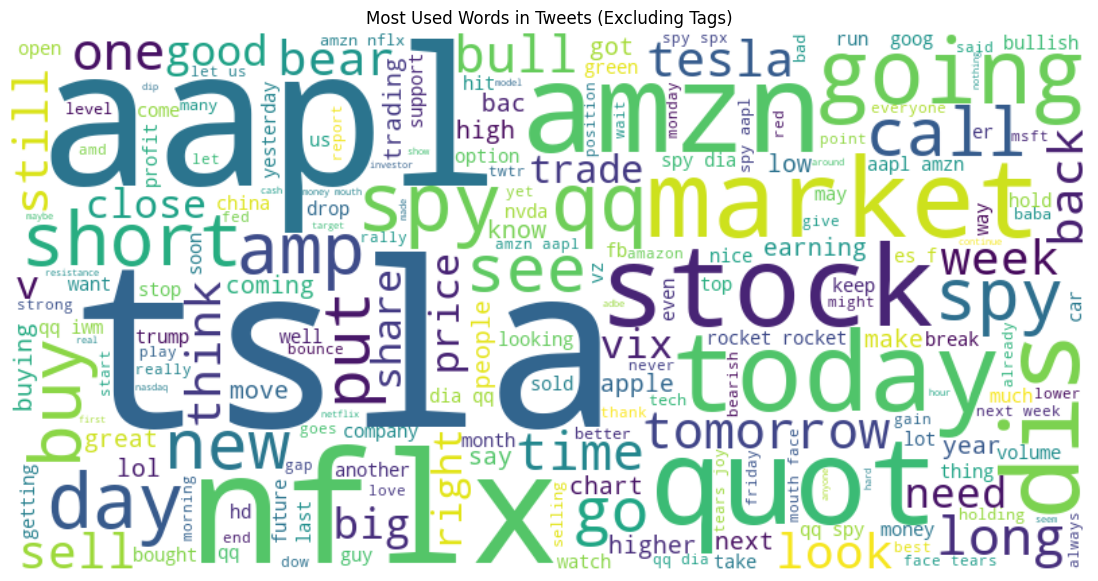

In [8]:
# Extract all words from cleaned_messages, excluding those with < or >
all_words = []
for message in tweets['cleaned_message'].dropna():
    words = str(message).split()
    # Filter out words containing < or >
    filtered_words = [word for word in words if '<' not in word and '>' not in word]
    all_words.extend(filtered_words)

# Join all words into a single string
text = ' '.join(all_words)

# Generate the wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)

# Display the wordcloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Used Words in Tweets (Excluding Tags)')
plt.show()

The word cloud above does not offer much insight as the most common words are "stock", "market", and "today" as well as the ticker symbols. We can remove ticker symbols to get a better idea. However, first we will perform sentiment analysis using two different methods to see if we can get more insight. 

## Task 3 - Sentiment Analysis

### FinBERT

In [9]:
model_name = "ProsusAI/finbert"

# Use the pipeline factory (simpler + handles device correctly)
pipe = pipeline(
    "text-classification",
    model=model_name,
    tokenizer=model_name,
    device=0 if torch.cuda.is_available() else -1,
    truncation=True
)

def finbert_label(text):
    # Skip bad/empty values
    if not isinstance(text, str) or not text.strip():
        return None
    # Pass raw text; no manual tokenization
    out = pipe(text, truncation=True, max_length=256)
    label = out[0]["label"].lower()
    if label == "positive":
        return 1
    if label == "negative":
        return -1
    return 0

# Ensure the column is string typed to avoid TextEncodeInput errors
tweets["cleaned_message"] = tweets["cleaned_message"].astype(str)

tweets["finbert_label"] = tweets["cleaned_message"].apply(finbert_label)

Device set to use cpu


In [10]:
tweets

,symbol,message,datetime,user,message_id,date,time,weekday,pct_before,pct_after,cleaned_message,finbert_label
0,AAPL,&quot;@optionfinity: $aapl mon. comes everyone...,2014-06-22 00:25:55-04:00,324130.0,24015204.0,2014-06-22,00:25:55,Sun,-0.010234,-0.005366,quot optionfinity aapl mon comes everyone kids...,0
1,QQQ,[video] broad market technical analysis: how t...,2019-11-18 20:33:51-05:00,385977.0,184185567.0,2019-11-18,20:33:51,Mon,0.002369,-0.002306,video broad market technical analysis trade cl...,0
2,JNJ,$jpm $wfc $t $sphd $o \n👉you buy undervalued d...,2020-05-28 16:13:33-04:00,1165200.0,215625215.0,2020-05-28,16:13:33,Thu,0.006506,0.005339,jpm wfc sphd backhand index pointing right buy...,0
3,AAPL,$aapl i have a ton of apple products at home. ...,2017-08-01 12:13:27-04:00,1137353.0,90556214.0,2017-08-01,12:13:27,Tue,-0.007805,0.006372,aapl ton apple products home 39 suspicious buy...,0
4,AAPL,$fb $amzn $googl $aapl,2019-06-03 14:55:00-04:00,1450539.0,166194132.0,2019-06-03,14:55:00,Mon,-0.006582,-0.013098,fb amzn googl aapl,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,AMZN,$amzn reuters saying 8.9 inch kindle fire comi...,2012-05-14 14:39:14-04:00,7108.0,7970956.0,2012-05-14,14:39:14,Mon,0.007657,-0.011835,amzn reuters saying 8 9 inch kindle fire comin...,0
9996,AAPL,$aapl man apple hired some losers for this app...,2016-06-13 13:22:30-04:00,380041.0,56558303.0,2016-06-13,13:22:30,Mon,0.003045,-0.013679,aapl man apple hired losers apple watch much u...,0
9997,V,"risk-adjusted landscape for visa($v), greenlig...",2020-03-25 15:48:33-04:00,56948.0,202711452.0,2020-03-25,15:48:33,Wed,0.066901,0.015441,risk adjusted landscape visa v greenlight insi...,0
9998,QQQ,$qqq half hour left and 40% less volume on day...,2018-01-11 15:31:18-05:00,367343.0,108610808.0,2018-01-11,15:31:18,Thu,0.002101,0.005109,qq half hour left 40 less volume day q,0


In [11]:
tweets['finbert_label'].value_counts()

finbert_label
 0    8362
-1     912
 1     726
Name: count, dtype: int64

We can see here that finBERT classifies most tweets as neutral, with a smaller number of tweets classified as positive and negative. This is not wholly unexpected as the majority of tweets may not express strong sentiments but offers little in the way of actionable insights.

 We also theorize that finBERT may not be the best model for tweets as it was trained on financial news articles, which are typically longer and more formal than tweets.

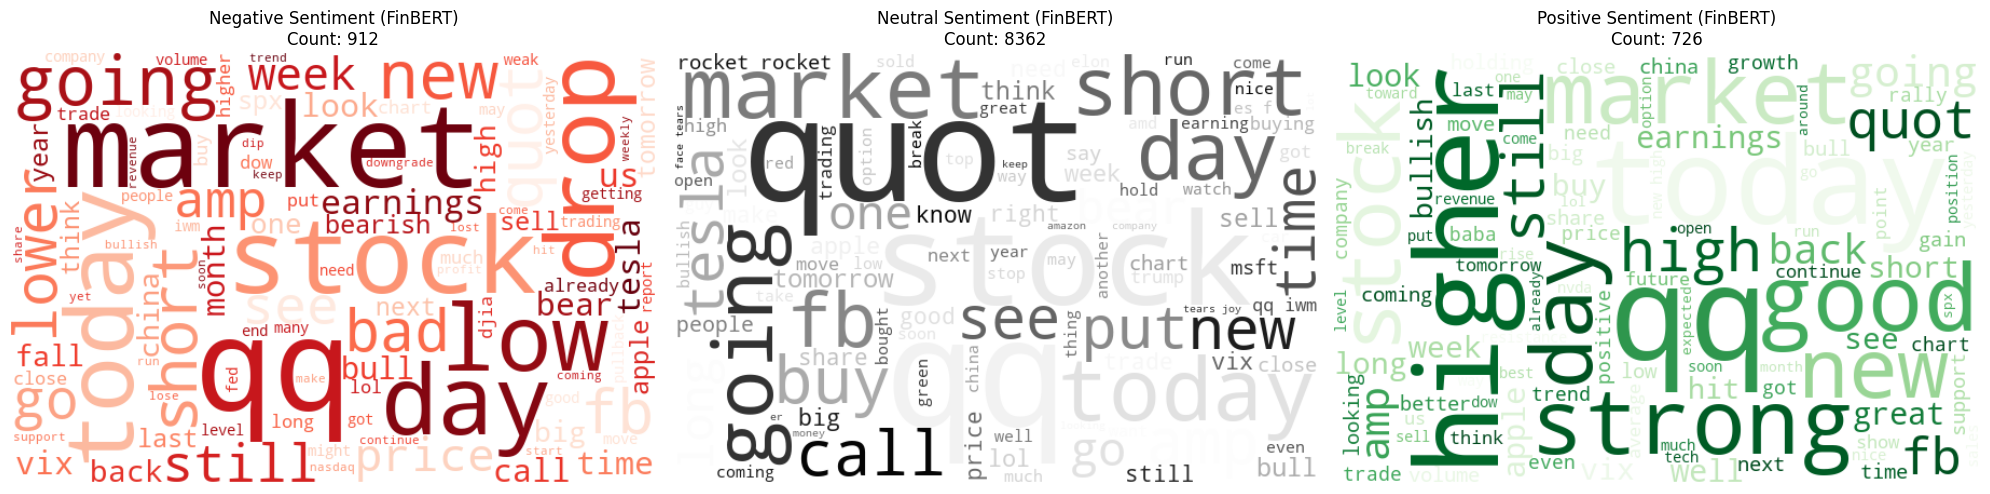

In [12]:
# Create separate word clouds for each FinBERT sentiment label with different colors
labels = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
colors = ['red', 'gray', 'green']  # Colors for negative, neutral, positive

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Get ticker symbols for filtering
ticker_symbols = set(tweets['symbol'].str.lower().unique())

for i, (label_val, label_name) in enumerate(labels.items()):
    # Filter tweets by FinBERT label
    filtered_tweets = tweets[tweets['finbert_label'] == label_val]
    
    if len(filtered_tweets) > 0:
        # Extract all words from cleaned_messages for this sentiment
        all_words = []
        for message in filtered_tweets['cleaned_message'].dropna():
            words = str(message).split()
            # Filter out words containing < or > AND ticker symbols
            filtered_words = [word for word in words 
                            if '<' not in word and '>' not in word 
                            and word.lower() not in ticker_symbols]
            all_words.extend(filtered_words)
        
        if all_words:  # Only create wordcloud if there are words
            # Join all words into a single string
            text = ' '.join(all_words)
            
            # Generate the wordcloud with specific colormap
            colormap_dict = {'red': 'Reds', 'gray': 'Greys', 'green': 'Greens'}
            wordcloud = WordCloud(
                width=600, 
                height=400, 
                background_color='white', 
                max_words=100,
                colormap=colormap_dict[colors[i]]
            ).generate(text)
            
            # Display the wordcloud
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].axis('off')
            axes[i].set_title(f'{label_name} Sentiment (FinBERT)\nCount: {len(filtered_tweets)}')
        else:
            axes[i].text(0.5, 0.5, f'No words found\nfor {label_name}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
            axes[i].set_title(f'{label_name} Sentiment (FinBERT)\nCount: {len(filtered_tweets)}')
    else:
        axes[i].text(0.5, 0.5, f'No tweets found\nfor {label_name}', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].axis('off')
        axes[i].set_title(f'{label_name} Sentiment (FinBERT)\nCount: 0')

plt.tight_layout()
plt.show()

Looking at the segmented word clouds, we see figures in line with what we would expect. Positive tweets contain words such as "good", "higher", "long" and "strong", while negative tweets contain words such as "short", "bad", "drop", and "lower". Neutral tweets contain more generic words such as "stock", "market", and "price".

This offers assurance that the classification is somewhat accurate.

### Twitter-RoBERTa

In [13]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"  # labels: negative / neutral / positive

# Use the pipeline factory (simpler + handles device correctly)
pipe = pipeline(
    "text-classification",
    model=model_name,
    tokenizer=model_name,
    device=0 if torch.cuda.is_available() else -1,   # int index, not torch.device
    truncation=True
)

def finbert_label(text):
    # Skip bad/empty values
    if not isinstance(text, str) or not text.strip():
        return None
    # Pass raw text; no manual tokenization
    out = pipe(text, truncation=True, max_length=256)
    label = out[0]["label"].lower()
    if label == "positive":
        return 1
    if label == "negative":
        return -1
    return 0

# Ensure the column is string typed to avoid TextEncodeInput errors
tweets["cleaned_message"] = tweets["cleaned_message"].astype(str)

tweets["roberta_label"] = tweets["cleaned_message"].apply(finbert_label)


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


In [14]:
tweets['roberta_label'].value_counts()

roberta_label
 0    7108
-1    1616
 1    1276
Name: count, dtype: int64

With twitter-RoBERTa, we see a more balanced distribution of sentiments, with a larger proportion of tweets classified as positive and negative compared to finBERT, although still skewed towards neutral sentiments. This may be due to twitter-RoBERTa being trained on a more diverse set of tweets, allowing it to better capture the nuances of sentiment in tweets.

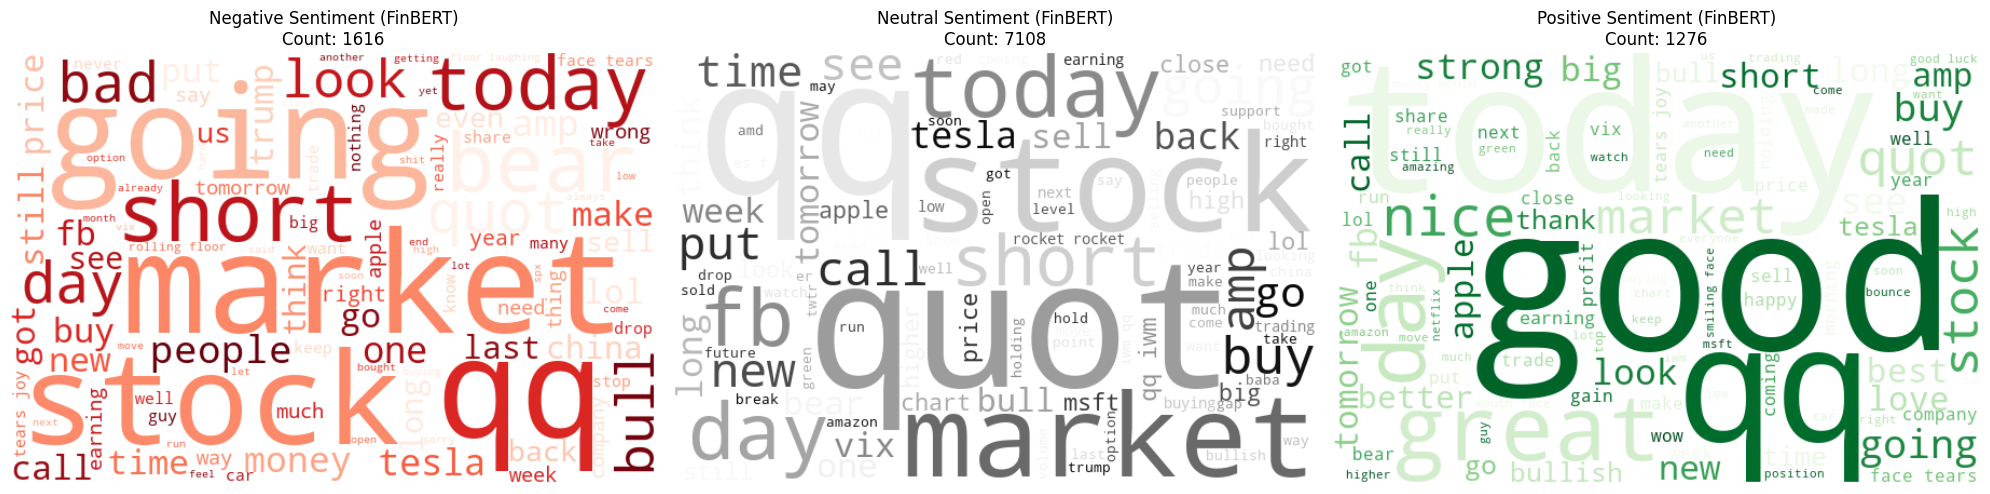

In [15]:
# Create separate word clouds for each FinBERT sentiment label with different colors
labels = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
colors = ['red', 'gray', 'green']  # Colors for negative, neutral, positive

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Get ticker symbols for filtering
ticker_symbols = set(tweets['symbol'].str.lower().unique())

for i, (label_val, label_name) in enumerate(labels.items()):
    # Filter tweets by FinBERT label
    filtered_tweets = tweets[tweets['roberta_label'] == label_val]
    
    if len(filtered_tweets) > 0:
        # Extract all words from cleaned_messages for this sentiment
        all_words = []
        for message in filtered_tweets['cleaned_message'].dropna():
            words = str(message).split()
            # Filter out words containing < or > AND ticker symbols
            filtered_words = [word for word in words 
                            if '<' not in word and '>' not in word 
                            and word.lower() not in ticker_symbols]
            all_words.extend(filtered_words)
        
        if all_words:  # Only create wordcloud if there are words
            # Join all words into a single string
            text = ' '.join(all_words)
            
            # Generate the wordcloud with specific colormap
            colormap_dict = {'red': 'Reds', 'gray': 'Greys', 'green': 'Greens'}
            wordcloud = WordCloud(
                width=600, 
                height=400, 
                background_color='white', 
                max_words=100,
                colormap=colormap_dict[colors[i]]
            ).generate(text)
            
            # Display the wordcloud
            axes[i].imshow(wordcloud, interpolation='bilinear')
            axes[i].axis('off')
            axes[i].set_title(f'{label_name} Sentiment (FinBERT)\nCount: {len(filtered_tweets)}')
        else:
            axes[i].text(0.5, 0.5, f'No words found\nfor {label_name}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].axis('off')
            axes[i].set_title(f'{label_name} Sentiment (FinBERT)\nCount: {len(filtered_tweets)}')
    else:
        axes[i].text(0.5, 0.5, f'No tweets found\nfor {label_name}', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].axis('off')
        axes[i].set_title(f'{label_name} Sentiment (FinBERT)\nCount: 0')

plt.tight_layout()
plt.show()

Once again, we see that the segmented word clouds align with our expectations. Positive tweets contain words such as "good", "great", and "buy", while negative tweets contain words such as "hate", "bear", and "short". Neutral tweets again contain more generic words such as "stock", "market", and "price". This further reinforces the accuracy of the sentiment classification. However, it is worth noting that it is not entirely accurate as 'bull' also appears in the negative word cloud, which is unexpected.

Overall, given that we have no benchmark to compare these results to, we can only theorize that twitter-RoBERTa may be the better model for sentiment analysis on tweets due to its more balanced classification and the fact that it was trained on tweets specifically. However, without further analysis or a benchmark, we cannot definitively conclude which model is superior.

In [16]:
# Compare FinBERT and RoBERTa labels to see how many rows have different predictions
different_labels = tweets[tweets['finbert_label'] != tweets['roberta_label']]
print(f"Number of rows with different sentiment labels between FinBERT and RoBERTa: {len(different_labels)}")
print(f"Percentage of disagreement: {len(different_labels) / len(tweets) * 100:.2f}%")

# Show breakdown of disagreements
print("\nBreakdown of disagreements:")
disagreement_crosstab = pd.crosstab(tweets['finbert_label'], tweets['roberta_label'], margins=True)
print(disagreement_crosstab)

Number of rows with different sentiment labels between FinBERT and RoBERTa: 3093
Percentage of disagreement: 30.93%

Breakdown of disagreements:
roberta_label    -1     0     1    All
finbert_label                         
-1              391   492    29    912
0              1183  6224   955   8362
1                42   392   292    726
All            1616  7108  1276  10000


Looking at the percentage of disagreements between the models, we see that they disagree on approximately 30% of tweets. This is a significant proportion and suggests that the models have different strengths and weaknesses.

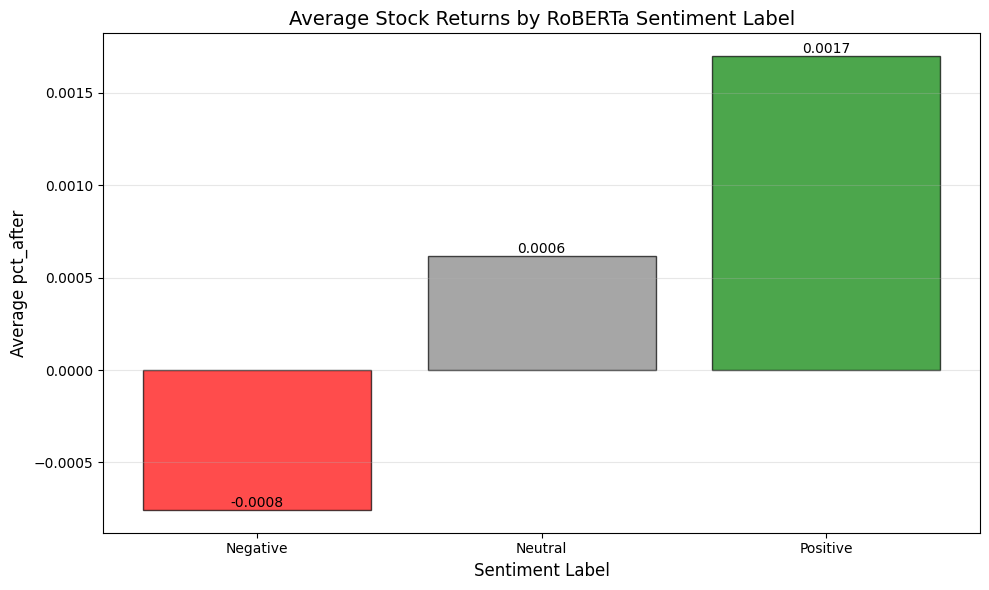

RoBERTa Sentiment Statistics:
Sentiment  Average_Return  Count
 Negative       -0.000757   1598
  Neutral        0.000618   6984
 Positive        0.001698   1259


In [17]:
# Calculate average pct_after for each RoBERTa sentiment label
roberta_sentiment_returns = tweets.groupby('roberta_label')['pct_after'].agg(['mean', 'count']).reset_index()
roberta_sentiment_returns.columns = ['Sentiment_Label', 'Average_Return', 'Count']

# Map labels to readable names
label_names = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
roberta_sentiment_returns['Sentiment'] = roberta_sentiment_returns['Sentiment_Label'].map(label_names)

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(roberta_sentiment_returns['Sentiment'], roberta_sentiment_returns['Average_Return'], 
               color=['red', 'gray', 'green'], alpha=0.7, edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom')

plt.title('Average Stock Returns by RoBERTa Sentiment Label', fontsize=14)
plt.xlabel('Sentiment Label', fontsize=12)
plt.ylabel('Average pct_after', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Display the statistics
print("RoBERTa Sentiment Statistics:")
print("="*40)
print(roberta_sentiment_returns[['Sentiment', 'Average_Return', 'Count']].to_string(index=False))

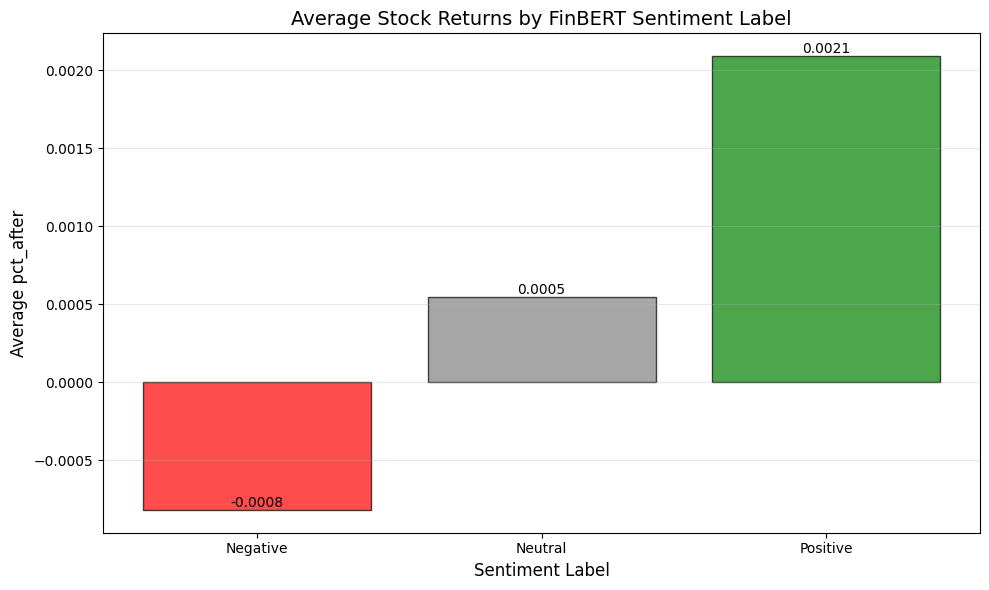

FinBERT Sentiment Statistics:
Sentiment  Average_Return  Count
 Negative       -0.000818    897
  Neutral        0.000545   8232
 Positive        0.002092    712


In [18]:
# Calculate average pct_after for each FinBERT sentiment label
finbert_sentiment_returns = tweets.groupby('finbert_label')['pct_after'].agg(['mean', 'count']).reset_index()
finbert_sentiment_returns.columns = ['Sentiment_Label', 'Average_Return', 'Count']

# Map labels to readable names
label_names = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}
finbert_sentiment_returns['Sentiment'] = finbert_sentiment_returns['Sentiment_Label'].map(label_names)

# Create the plot
plt.figure(figsize=(10, 6))
bars = plt.bar(finbert_sentiment_returns['Sentiment'], finbert_sentiment_returns['Average_Return'], 
               color=['red', 'gray', 'green'], alpha=0.7, edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom')

plt.title('Average Stock Returns by FinBERT Sentiment Label', fontsize=14)
plt.xlabel('Sentiment Label', fontsize=12)
plt.ylabel('Average pct_after', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Display the statistics
print("FinBERT Sentiment Statistics:")
print("="*40)
print(finbert_sentiment_returns[['Sentiment', 'Average_Return', 'Count']].to_string(index=False))

Comparing the average returns of both models, we see that tweets classified as positive by either model are associated with higher average returns the next day, while tweets classified as negative are associated with lower average returns. However, the differences are more pronounced for **twitter-RoBERTa**, further suggesting that it may be the superior model for this task. 

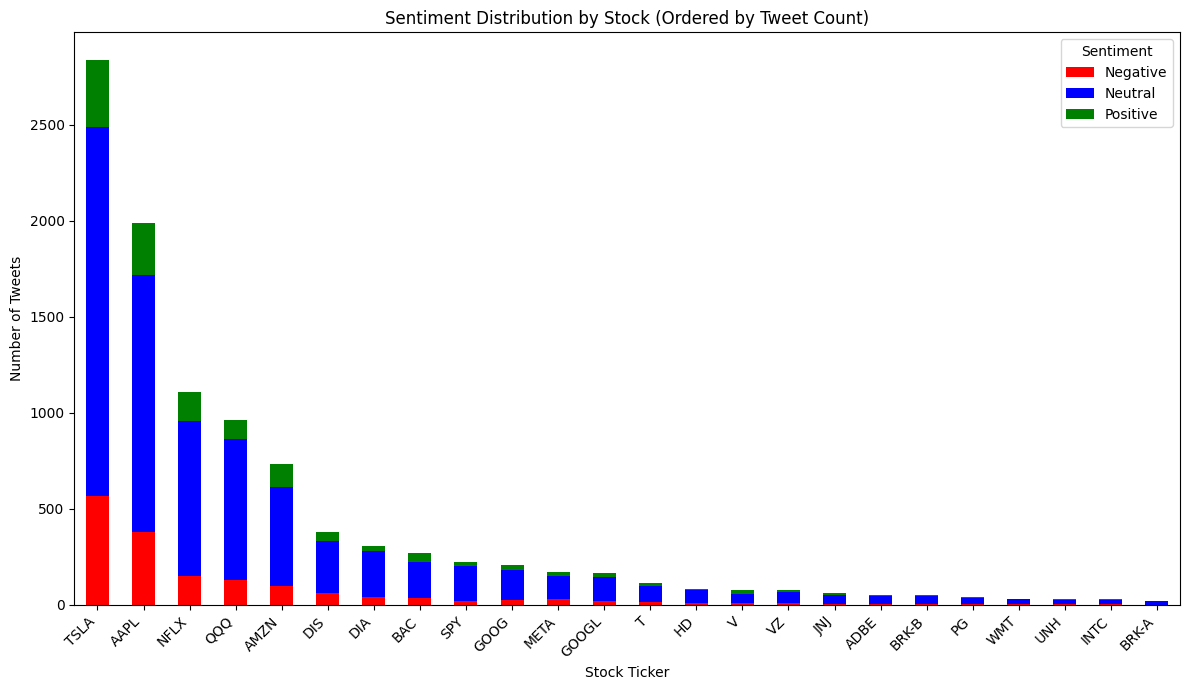

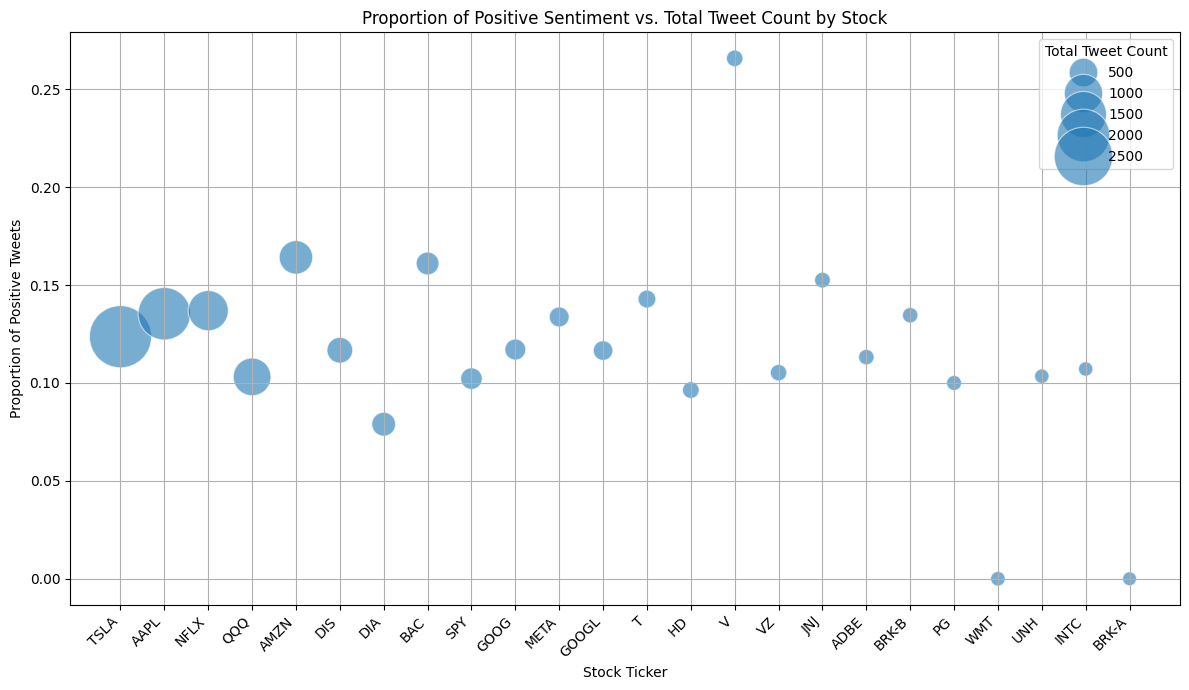

In [21]:
sentiment_by_stock = tweets.groupby(['symbol', 'roberta_label']).size().unstack(fill_value=0)

# Map numeric labels to readable names
sentiment_by_stock.columns = ['Negative', 'Neutral', 'Positive']

# Order the stocks by the total number of tweets (most to fewest)
sentiment_by_stock_ordered = sentiment_by_stock.sum(axis=1).sort_values(ascending=False)
sentiment_by_stock_ordered = sentiment_by_stock.loc[sentiment_by_stock_ordered.index]

# Ensure the order of colors matches the order of columns in sentiment_by_stock_ordered (Negative, Neutral, Positive)
custom_palette = {'Negative': 'red', 'Neutral': 'blue', 'Positive': 'green'}

# Plotting the sentiment distribution for each stock (ordered and with custom colors)
sentiment_by_stock_ordered[['Negative', 'Neutral', 'Positive']].plot(kind='bar', stacked=True, figsize=(12, 7), color=[custom_palette[col] for col in ['Negative', 'Neutral', 'Positive']])
plt.title('Sentiment Distribution by Stock (Ordered by Tweet Count)')
plt.xlabel('Stock Ticker')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


# Normalize sentiment counts to get proportions for each stock
sentiment_by_stock_normalized_ordered = sentiment_by_stock_ordered.div(sentiment_by_stock_ordered.sum(axis=1), axis=0)

# Scatter plot of proportion of positive sentiment vs. total tweet count
import seaborn as sns
plt.figure(figsize=(12, 7))
ax = sns.scatterplot(
	x=range(len(sentiment_by_stock_ordered.index)),
	y=sentiment_by_stock_normalized_ordered['Positive'],
	size=sentiment_by_stock_ordered.sum(axis=1),
	sizes=(100, 2000),
	alpha=0.6
)
plt.xticks(range(len(sentiment_by_stock_ordered.index)), sentiment_by_stock_ordered.index, rotation=45, ha='right')
plt.title('Proportion of Positive Sentiment vs. Total Tweet Count by Stock')
plt.xlabel('Stock Ticker')
plt.ylabel('Proportion of Positive Tweets')
plt.grid(True)

# Add title to the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, title='Total Tweet Count')

plt.tight_layout()
plt.show()

## Task 4 - Media Attention

This scoring system measures abnormal sentiment-weighted attention around a stock by combining tweet volume and sentiment intensity over time. It first assigns each tweet a sentiment weight (based on model output from RoBERTa), then aggregates this at the daily level to capture both how many people are talking about the stock and how strongly positive or negative their opinions are. A log transformation normalizes large spikes in tweet activity, and the model then compares current weighted sentiment attention against a historical average to isolate abnormal surges in emotionally charged discussion. Such a framework allows for a nuanced understanding of market sentiment dynamics, potentially offering valuable insights for traders and analysts alike.

However, a key weakness is that it assumes all tweets and users contribute equally to market impact, where in reality, this may not be true.

In [22]:
def calculate_sentiment_weighted_abnormal_attention(tweets):
    tweets['date'] = pd.to_datetime(tweets['date'])
    
    # Create sentiment weights: emphasize extreme sentiments
    tweets['sentiment_weight'] = tweets['roberta_label']  # -1, 0, 1 for negative, neutral, positive
    
    # Calculate daily sentiment-weighted tweet counts
    daily_weighted = tweets.groupby(['symbol', 'date']).agg({
        'sentiment_weight': 'sum',          # Total sentiment intensity (can be negative)
        'roberta_label': ['count', 'mean']  # Tweet count and average sentiment
    }).reset_index()
    
    # Flatten column names
    daily_weighted.columns = ['symbol', 'date', 'weighted_count', 'tweet_count', 'avg_sentiment']
    
    # Handle negative weighted counts by using signed log
    daily_weighted['log_weighted_count'] = np.sign(daily_weighted['weighted_count']) * np.log(1 + np.abs(daily_weighted['weighted_count']))
    
    # Calculate abnormal sentiment-weighted attention with proper grouping
    daily_weighted['historical_weighted_avg'] = daily_weighted.groupby('symbol')['log_weighted_count'].expanding().mean().reset_index(level=0, drop=True)
    daily_weighted['abnormal_sentiment_attention'] = daily_weighted['log_weighted_count'] - daily_weighted['historical_weighted_avg']
    
    # Fill NaN values for first observation of each symbol
    daily_weighted['abnormal_sentiment_attention'] = daily_weighted['abnormal_sentiment_attention'].fillna(0)
    
    return daily_weighted

In [26]:
def calculate_abnormal_media_attention(tweets):
    tweets['date'] = pd.to_datetime(tweets['date'])
    # Count tweets per symbol per date
    daily_counts = tweets.groupby(['symbol', 'date']).size().reset_index(name='tweet_count')
    # Log-transform to normalize spikes
    daily_counts['log_tweet_count'] = np.log1p(daily_counts['tweet_count'])
    # Calculate historical average (expanding mean)
    daily_counts['historical_avg'] = daily_counts.groupby('symbol')['log_tweet_count'].expanding().mean().reset_index(level=0, drop=True)
    # Abnormal attention = current - historical average
    daily_counts['abnormal_media_attention'] = daily_counts['log_tweet_count'] - daily_counts['historical_avg']
    daily_counts['abnormal_media_attention'] = daily_counts['abnormal_media_attention'].fillna(0)
    return daily_counts

def implement_enhanced_media_attention_analysis(tweets):
    # Calculate basic abnormal media attention
    basic_attention = calculate_abnormal_media_attention(tweets)
    
    # Calculate sentiment-weighted abnormal attention
    sentiment_attention = calculate_sentiment_weighted_abnormal_attention(tweets)
    
    # Merge both measures
    combined_attention = basic_attention.merge(
        sentiment_attention[['symbol', 'date', 'weighted_count', 'abnormal_sentiment_attention', 'avg_sentiment']], 
        on=['symbol', 'date']
    )
    
    # Merge with original tweet data
    merged_data = tweets.merge(combined_attention, on=['symbol', 'date'])
    
    
    return merged_data

# Run the enhanced analysis
tweets_with_enhanced_attention = implement_enhanced_media_attention_analysis(tweets)

In [27]:
tweets_with_enhanced_attention

,symbol,message,datetime,user,message_id,date,time,weekday,pct_before,pct_after,...,finbert_label,roberta_label,sentiment_weight,tweet_count,log_tweet_count,historical_avg,abnormal_media_attention,weighted_count,abnormal_sentiment_attention,avg_sentiment
0,AAPL,&quot;@optionfinity: $aapl mon. comes everyone...,2014-06-22 00:25:55-04:00,324130.0,24015204.0,2014-06-22,00:25:55,Sun,-0.010234,-0.005366,...,0,0,0,1,0.693147,0.835996,-0.142848,0,0.017491,0.000000
1,QQQ,[video] broad market technical analysis: how t...,2019-11-18 20:33:51-05:00,385977.0,184185567.0,2019-11-18,20:33:51,Mon,0.002369,-0.002306,...,0,0,0,2,1.098612,0.810481,0.288131,1,0.715165,0.500000
2,JNJ,$jpm $wfc $t $sphd $o \n👉you buy undervalued d...,2020-05-28 16:13:33-04:00,1165200.0,215625215.0,2020-05-28,16:13:33,Thu,0.006506,0.005339,...,0,0,0,1,0.693147,0.717972,-0.024824,0,-0.070729,0.000000
3,AAPL,$aapl i have a ton of apple products at home. ...,2017-08-01 12:13:27-04:00,1137353.0,90556214.0,2017-08-01,12:13:27,Tue,-0.007805,0.006372,...,0,-1,-1,3,1.386294,0.877890,0.508404,-2,-1.050846,-0.666667
4,AAPL,$fb $amzn $googl $aapl,2019-06-03 14:55:00-04:00,1450539.0,166194132.0,2019-06-03,14:55:00,Mon,-0.006582,-0.013098,...,0,0,0,3,1.386294,0.908639,0.477655,-1,-0.638803,-0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,AMZN,$amzn reuters saying 8.9 inch kindle fire comi...,2012-05-14 14:39:14-04:00,7108.0,7970956.0,2012-05-14,14:39:14,Mon,0.007657,-0.011835,...,0,0,0,1,0.693147,0.712455,-0.019308,0,-0.066014,0.000000
9996,AAPL,$aapl man apple hired some losers for this app...,2016-06-13 13:22:30-04:00,380041.0,56558303.0,2016-06-13,13:22:30,Mon,0.003045,-0.013679,...,0,-1,-1,7,2.079442,0.886664,1.192778,-1,-0.639826,-0.142857
9997,V,"risk-adjusted landscape for visa($v), greenlig...",2020-03-25 15:48:33-04:00,56948.0,202711452.0,2020-03-25,15:48:33,Wed,0.066901,0.015441,...,0,0,0,1,0.693147,0.705073,-0.011925,0,-0.122320,0.000000
9998,QQQ,$qqq half hour left and 40% less volume on day...,2018-01-11 15:31:18-05:00,367343.0,108610808.0,2018-01-11,15:31:18,Thu,0.002101,0.005109,...,0,0,0,3,1.386294,0.770502,0.615792,0,0.004415,0.000000


In [28]:
tweets_with_enhanced_attention.columns

Index(['symbol', 'message', 'datetime', 'user', 'message_id', 'date', 'time',
       'weekday', 'pct_before', 'pct_after', 'cleaned_message',
       'finbert_label', 'roberta_label', 'sentiment_weight', 'tweet_count',
       'log_tweet_count', 'historical_avg', 'abnormal_media_attention',
       'weighted_count', 'abnormal_sentiment_attention', 'avg_sentiment'],
      dtype='object')

Here we remove not unneccessary columns

In [ ]:
tweets_with_enhanced_attention = tweets_with_enhanced_attention.drop(
	columns=[
		'datetime', 'user', 'message_id', 'weekday', 'sentiment_weight',
		'tweet_count', 'historical_avg', 'weighted_count', 'avg_sentiment'
	]
)

In [31]:
tweets_with_enhanced_attention.columns

Index(['symbol', 'message', 'date', 'time', 'pct_before', 'pct_after',
       'cleaned_message', 'finbert_label', 'roberta_label', 'log_tweet_count',
       'abnormal_media_attention', 'abnormal_sentiment_attention'],
      dtype='object')

### Regressions

In [32]:
# Perform regression analysis of pct_after on abnormal_attention using statsmodels
def regression_analysis(tweets_with_enhanced_attention):
    # Remove rows with missing values
    clean_data = tweets_with_enhanced_attention.dropna(subset=['pct_after', 'abnormal_sentiment_attention'])
    
    # Define independent and dependent variables
    X = clean_data['abnormal_sentiment_attention']
    y = clean_data['pct_after']
    
    # Add constant for intercept
    X = sm.add_constant(X)
    
    # Fit the regression model
    model = sm.OLS(y, X).fit()
    
    # Print regression results
    print("Regression Results: pct_after ~ abnormal_sentiment_attention")
    print("=" * 60)
    print(model.summary())
    

    return model

# Run the regression analysis
regression_model = regression_analysis(tweets_with_enhanced_attention)

Regression Results: pct_after ~ abnormal_sentiment_attention
                            OLS Regression Results                            
Dep. Variable:              pct_after   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     45.75
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           1.42e-11
Time:                        00:36:19   Log-Likelihood:                 21725.
No. Observations:                9841   AIC:                        -4.345e+04
Df Residuals:                    9839   BIC:                        -4.343e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

Running an OLS regression of next day returns against abnormal sentiment-weighted attention, we find a statistically significant positive relationship. This suggests that days with unusually high levels of positive sentiment-weighted attention are associated with higher stock returns the following day. This provides positive evidence that our media attention measure captures meaningful information about market sentiment that can predict short-term stock performance.

### Adding the previous day's return as a control variable

In [33]:
# Drop rows where pct_before is NaN
tweets_with_enhanced_attention = tweets_with_enhanced_attention.dropna(subset=['pct_before'])

In [34]:
tweets_with_enhanced_attention['pct_before'].isna().sum()

0

In [35]:
import statsmodels.api as sm

# Perform regression analysis of pct_after on abnormal_attention using statsmodels
def regression_analysis(tweets_with_attention):
    # Remove rows with missing values
    clean_data = tweets_with_attention.dropna(subset=['pct_after', 'abnormal_sentiment_attention'])
    
    # Define independent and dependent variables
    X = clean_data[['abnormal_sentiment_attention', 'pct_before']]
    y = clean_data['pct_after']

    # Add constant for intercept
    X = sm.add_constant(X)
    
    # Fit the regression model
    model = sm.OLS(y, X).fit()
    
    # Print regression results
    print("Regression Results: pct_after ~ abnormal_sentiment_attention")
    print("=" * 60)
    print(model.summary())
    

    return model

# Run the regression analysis
regression_model = regression_analysis(tweets_with_enhanced_attention)

Regression Results: pct_after ~ abnormal_sentiment_attention
                            OLS Regression Results                            
Dep. Variable:              pct_after   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     92.92
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           1.08e-40
Time:                        00:36:29   Log-Likelihood:                 21288.
No. Observations:                9569   AIC:                        -4.257e+04
Df Residuals:                    9566   BIC:                        -4.255e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

Once again, we see that the media attention variable remains statistically significant even after controlling for the previous day's return. This suggests that the abnormal sentiment-weighted attention measure captures unique information about market sentiment that is not already reflected in recent price movements. Moreover, we see that the returns in the day before are also statistically significant, and negatively correlated with next day returns. This indicates a mean-reverting behavior, where stocks that performed well yesterday tend to perform worse today, and vice versa.

### Creating 10 portfolios based on media attention

/var/folders/b0/h1xx55fn0m7f9j3k4jxny4nm0000gn/T/ipykernel_3972/4172863657.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  portfolio_returns = tweets_with_enhanced_attention.groupby('portfolio')['pct_after'].agg(['mean', 'count']).reset_index()


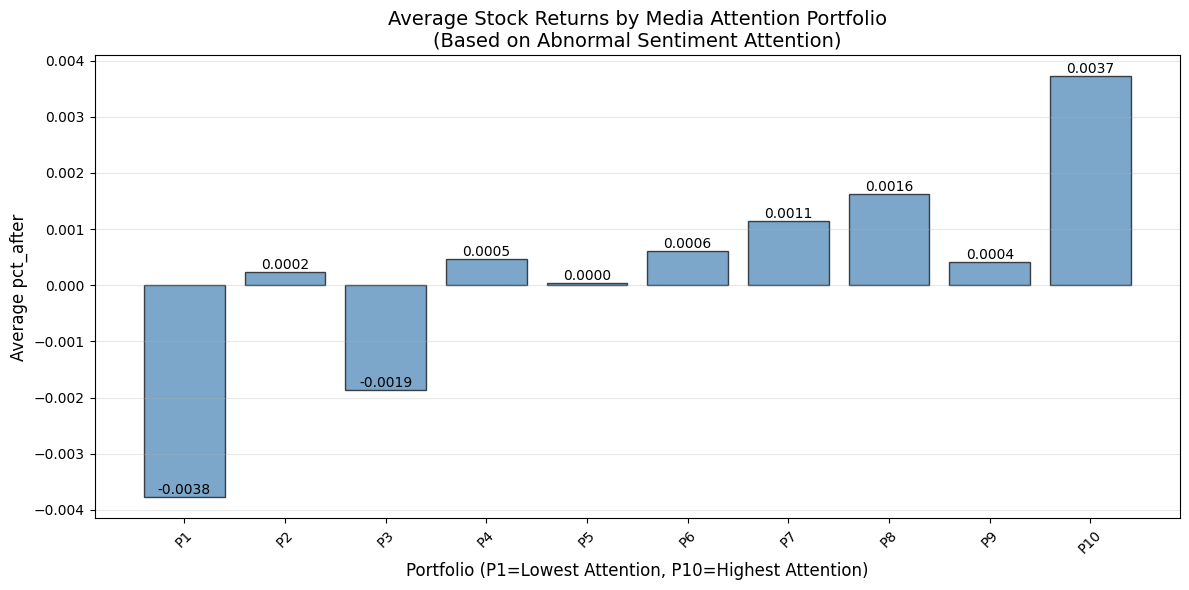

In [36]:
# Create 10 portfolios based on deciles of abnormal_sentiment_attention for the entire dataset
tweets_with_enhanced_attention['portfolio'] = pd.qcut(
    tweets_with_enhanced_attention['abnormal_sentiment_attention'], 
    q=10, 
    labels=[f'P{j+1}' for j in range(10)]
)

portfolio_returns = tweets_with_enhanced_attention.groupby('portfolio')['pct_after'].agg(['mean', 'count']).reset_index()
portfolio_returns.columns = ['Portfolio', 'Average_Return', 'Count']

# Create the plot
plt.figure(figsize=(12, 6))
bars = plt.bar(portfolio_returns['Portfolio'], portfolio_returns['Average_Return'], 
               color='steelblue', alpha=0.7, edgecolor='black')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}', ha='center', va='bottom')

plt.title('Average Stock Returns by Media Attention Portfolio\n(Based on Abnormal Sentiment Attention)', fontsize=14)
plt.xlabel('Portfolio (P1=Lowest Attention, P10=Highest Attention)', fontsize=12)
plt.ylabel('Average pct_after', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The above plot shows the cumulative returns of 10 portfolios formed based on the abnormal sentiment-weighted attention measure. We can see that the portfolio with the highest media attention (Portfolio 10) significantly outperforms the others, while the portfolio with the lowest media attention (Portfolio 1) underperforms. This suggests that stocks experiencing unusually high levels of positive attention tend to deliver superior returns over time, while those with low attention lag behind. The clear separation between the top and bottom portfolios indicates that our media attention measure effectively captures information relevant to stock performance.

### Fama French Analysis

In [37]:
FF = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.csv')

In [38]:
FF

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,19630701,-0.67,0.02,-0.35,0.03,0.13,0.012
1,19630702,0.79,-0.28,0.28,-0.08,-0.21,0.012
2,19630703,0.63,-0.18,-0.10,0.13,-0.25,0.012
3,19630705,0.40,0.09,-0.28,0.07,-0.30,0.012
4,19630708,-0.63,0.07,-0.20,-0.27,0.06,0.012
...,...,...,...,...,...,...,...
15476,20241224,1.11,-0.12,-0.05,-0.13,-0.37,0.017
15477,20241226,0.02,1.09,-0.19,-0.44,0.35,0.017
15478,20241227,-1.17,-0.44,0.56,0.41,0.03,0.017
15479,20241230,-1.09,0.24,0.74,0.55,0.14,0.017


In [39]:
FF['date'] = pd.to_datetime(FF['Date'].astype(str), format="%Y%m%d")

In [40]:
FF

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF,date
0,19630701,-0.67,0.02,-0.35,0.03,0.13,0.012,1963-07-01
1,19630702,0.79,-0.28,0.28,-0.08,-0.21,0.012,1963-07-02
2,19630703,0.63,-0.18,-0.10,0.13,-0.25,0.012,1963-07-03
3,19630705,0.40,0.09,-0.28,0.07,-0.30,0.012,1963-07-05
4,19630708,-0.63,0.07,-0.20,-0.27,0.06,0.012,1963-07-08
...,...,...,...,...,...,...,...,...
15476,20241224,1.11,-0.12,-0.05,-0.13,-0.37,0.017,2024-12-24
15477,20241226,0.02,1.09,-0.19,-0.44,0.35,0.017,2024-12-26
15478,20241227,-1.17,-0.44,0.56,0.41,0.03,0.017,2024-12-27
15479,20241230,-1.09,0.24,0.74,0.55,0.14,0.017,2024-12-30


In [41]:
FF = FF.drop('Date', axis=1)
FF.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF,date
0,-0.67,0.02,-0.35,0.03,0.13,0.012,1963-07-01
1,0.79,-0.28,0.28,-0.08,-0.21,0.012,1963-07-02
2,0.63,-0.18,-0.10,0.13,-0.25,0.012,1963-07-03
3,0.40,0.09,-0.28,0.07,-0.30,0.012,1963-07-05
4,-0.63,0.07,-0.20,-0.27,0.06,0.012,1963-07-08


In [42]:
# Convert both to date objects
tweets_with_enhanced_attention['date'] = pd.to_datetime(tweets_with_enhanced_attention['date']).dt.date
FF['date'] = pd.to_datetime(FF['date']).dt.date

# Merge FF data with tweets_with_enhanced_attention based on date
tweets_with_ff = tweets_with_enhanced_attention.merge(FF, on='date', how='left')

# Display the merged dataframe
tweets_with_ff.head()

,symbol,message,date,time,pct_before,pct_after,cleaned_message,finbert_label,roberta_label,log_tweet_count,abnormal_media_attention,abnormal_sentiment_attention,portfolio,Mkt-RF,SMB,HML,RMW,CMA,RF
0,AAPL,&quot;@optionfinity: $aapl mon. comes everyone...,2014-06-22,00:25:55,-0.010234,-0.005366,quot optionfinity aapl mon comes everyone kids...,0,0,0.693147,-0.142848,0.017491,P6,NaN,NaN,NaN,NaN,NaN,NaN
1,QQQ,[video] broad market technical analysis: how t...,2019-11-18,20:33:51,0.002369,-0.002306,video broad market technical analysis trade cl...,0,0,1.098612,0.288131,0.715165,P10,0.02,-0.36,-0.52,-0.03,-0.33,0.006
2,JNJ,$jpm $wfc $t $sphd $o \n👉you buy undervalued d...,2020-05-28,16:13:33,0.006506,0.005339,jpm wfc sphd backhand index pointing right buy...,0,0,0.693147,-0.024824,-0.070729,P4,-0.41,-2.07,-2.43,-0.24,0.09,0.000
3,AAPL,$aapl i have a ton of apple products at home. ...,2017-08-01,12:13:27,-0.007805,0.006372,aapl ton apple products home 39 suspicious buy...,0,-1,1.386294,0.508404,-1.050846,P1,0.24,-0.13,0.14,0.27,-0.50,0.004
4,AAPL,$fb $amzn $googl $aapl,2019-06-03,14:55:00,-0.006582,-0.013098,fb amzn googl aapl,0,0,1.386294,0.477655,-0.638803,P3,-0.40,0.58,1.66,0.27,1.39,0.009


In [43]:
# Fill missing values in the Fama-French factors with forward fill method
tweets_with_ff[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] = tweets_with_ff[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].fillna(method='ffill')

# Check for remaining missing values
print("Missing values after forward fill:")
print(tweets_with_ff[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].isnull().sum())

Missing values after forward fill:
Mkt-RF    1
SMB       1
HML       1
RMW       1
CMA       1
RF        1
dtype: int64


/var/folders/b0/h1xx55fn0m7f9j3k4jxny4nm0000gn/T/ipykernel_3972/913803568.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tweets_with_ff[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] = tweets_with_ff[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].fillna(method='ffill')


In [44]:
# Fill missing values in the Fama-French factors with backward fill method
tweets_with_ff[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] = tweets_with_ff[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].fillna(method='bfill')

# Check for remaining missing values
print("Missing values after backward fill:")
print(tweets_with_ff[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].isnull().sum())

Missing values after backward fill:
Mkt-RF    0
SMB       0
HML       0
RMW       0
CMA       0
RF        0
dtype: int64


/var/folders/b0/h1xx55fn0m7f9j3k4jxny4nm0000gn/T/ipykernel_3972/2696796119.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tweets_with_ff[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']] = tweets_with_ff[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']].fillna(method='bfill')


In [45]:
import statsmodels.api as sm

# Create a regression of pct_after on Fama-French factors
def fama_french_regression(tweets_ff):
    # Remove rows with missing values
    clean_data = tweets_ff.dropna(subset=['pct_after', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF'])
    
    # Define independent variables (Fama-French factors)
    X = clean_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]
    y = clean_data['pct_after']
    
    # Add constant for intercept
    X = sm.add_constant(X)
    
    # Fit the regression model
    model = sm.OLS(y, X).fit()
    
    # Print regression results
    print("Fama-French Regression Results: pct_after ~ Mkt-RF + SMB + HML + RMW + CMA + RF")
    print("=" * 80)
    print(model.summary())
    
    # Calculate and save residuals
    residuals = model.resid
    
    # Add residuals back to the dataframe
    tweets_ff.loc[clean_data.index, 'ff_residuals'] = residuals
    
    return model, residuals

# Run the Fama-French regression
ff_model, ff_residuals = fama_french_regression(tweets_with_ff)

Fama-French Regression Results: pct_after ~ Mkt-RF + SMB + HML + RMW + CMA + RF
                            OLS Regression Results                            
Dep. Variable:              pct_after   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     111.7
Date:                Mon, 06 Oct 2025   Prob (F-statistic):          1.04e-136
Time:                        00:36:48   Log-Likelihood:                 21520.
No. Observations:                9569   AIC:                        -4.303e+04
Df Residuals:                    9562   BIC:                        -4.298e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

Interestingly, running a Fama-French regression on the dataset, we find that the coefficients are small in magnitude but statistically significant at the 1% level except for RF, which is significant at the 10% level.

In [46]:
import statsmodels.api as sm

# Perform regression analysis of ff_residuals on abnormal_sentiment_attention
def residuals_regression_analysis(tweets_ff):
    # Remove rows with missing values
    clean_data = tweets_ff.dropna(subset=['ff_residuals', 'abnormal_sentiment_attention'])
    
    # Define independent and dependent variables
    X = clean_data['abnormal_sentiment_attention']
    y = clean_data['ff_residuals']
    
    # Add constant for intercept
    X = sm.add_constant(X)
    
    # Fit the regression model
    model = sm.OLS(y, X).fit()
    
    # Print regression results
    print("Regression Results: ff_residuals ~ abnormal_sentiment_attention")
    print("=" * 60)
    print(model.summary())
    
    return model

# Run the regression analysis
residuals_model = residuals_regression_analysis(tweets_with_ff)

Regression Results: ff_residuals ~ abnormal_sentiment_attention
                            OLS Regression Results                            
Dep. Variable:           ff_residuals   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     24.27
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           8.52e-07
Time:                        00:36:51   Log-Likelihood:                 21532.
No. Observations:                9569   AIC:                        -4.306e+04
Df Residuals:                    9567   BIC:                        -4.305e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

Running a regression on the residuals of the Fama-French model against our media attention variable, we find that the media attention variable remains statistically significant. This suggests that our media attention measure captures information about stock returns that is not already explained by the Fama-French factors, further reinforcing its potential utility for predicting stock performance. We have that 2.3% of the variation in returns is explained by our media attention variable, which, while not large, is still meaningful in the context of stock return prediction. 

Given the small magnitude of the coefficients, it is important to note that, if FF is the true model, the economic significance of our media attention variable may be limited. However, its statistical significance suggests that it does capture some unique information about stock returns.

## EXTRA - Granger Causality

### Granger Causality on Media Attention and Stock Returns

For our own personal interest, we decided to implement Granger Causality tests to see if tweet sentiment causes stock returns or if stock returns cause tweet sentiment.

In this section, we perform Granger Causality tests to examine the potential causal relationship between media attention and stock returns. We first ensure that both time series are stationary, a prerequisite for valid Granger causality testing.

In [54]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

# --- build base df with your columns ---
base = tweets_with_ff[['symbol', 'date', 'pct_after', 'abnormal_sentiment_attention']].copy()
base = base.rename(columns={'pct_after': 'returns', 'abnormal_sentiment_attention': 'media_attention'})
base['date'] = pd.to_datetime(base['date'], errors='coerce')
base = base.dropna(subset=['symbol', 'date']).sort_values('date')

maxlag_global = 5
alpha = 0.05  # ADF threshold

def make_stationary(s: pd.Series):
    s = s.dropna()
    if len(s) < 10:
        return s, np.nan, False
    try:
        stat, p, *_ = adfuller(s, autolag='AIC')
    except Exception:
        return s, np.nan, False
    if p is not None and p > alpha:
        return s.diff().dropna(), p, True
    return s, p, False

def allowable_maxlag(n_obs: int, desired_maxlag: int, addconst: int = 1) -> int:
    """statsmodels requires n > 3*lag + addconst  ->  lag <= floor((n - addconst)/3) - 1"""
    max_allowed = int((n_obs - addconst) / 3) - 1
    return max(0, min(desired_maxlag, max_allowed))

symbols = base['symbol'].unique()
print(f"\n=== Per-symbol Granger causality (max desired lag={maxlag_global}) ===\n")

for sym in symbols:
    sub = base[base['symbol'] == sym].copy()
    # Aggregate to daily frequency to ensure unique dates per symbol
    sub = sub.groupby('date')[['returns', 'media_attention']].mean().astype(float)

    # Stationarity (difference once if ADF fails)
    y_raw, p_y, d_y = make_stationary(sub['returns'])
    x_raw, p_x, d_x = make_stationary(sub['media_attention'])

    # Align after differencing
    df = pd.concat([y_raw.rename('returns'), x_raw.rename('media_attention')], axis=1).dropna()
    n = len(df)
    if n < 10:
        print(f"[{sym}] skipped (n={n} < 10).")
        continue

    # Check for constant series (zero variance)
    if df['returns'].nunique() == 1 or df['media_attention'].nunique() == 1:
        print(f"[{sym}] skipped (constant series after differencing).")
        continue

    # Clamp lag per symbol to avoid "Insufficient observations" error
    maxlag_sym = allowable_maxlag(n_obs=n, desired_maxlag=maxlag_global, addconst=1)
    if maxlag_sym < 1:
        print(f"[{sym}] skipped (n={n} → allowable maxlag={maxlag_sym} < 1).")
        continue

    print(f"[{sym}] n={n} | maxlag={maxlag_sym} | ADF p(returns)={p_y if p_y==p_y else float('nan'):.3g} diff={d_y} | "
          f"ADF p(media)={p_x if p_x==p_x else float('nan'):.3g} diff={d_x}")

    # Direction 1: media_attention → returns
    res1 = grangercausalitytests(df[['returns', 'media_attention']], maxlag=maxlag_sym, verbose=False)
    pvals1 = {lag: tests[0]['ssr_chi2test'][1] for lag, tests in res1.items() if 'ssr_chi2test' in tests[0]}

    # Direction 2: returns → media_attention
    res2 = grangercausalitytests(df[['media_attention', 'returns']], maxlag=maxlag_sym, verbose=False)
    pvals2 = {lag: tests[0]['ssr_chi2test'][1] for lag, tests in res2.items() if 'ssr_chi2test' in tests[0]}

    best_lag1 = min(pvals1, key=pvals1.get)
    best_lag2 = min(pvals2, key=pvals2.get)
    print(f"  media_attention → returns : min p={pvals1[best_lag1]:.3g} at lag {best_lag1}")
    print(f"  returns → media_attention : min p={pvals2[best_lag2]:.3g} at lag {best_lag2}\n")



=== Per-symbol Granger causality (max desired lag=5) ===

[AAPL] n=1137 | maxlag=5 | ADF p(returns)=0 diff=False | ADF p(media)=0 diff=False
  media_attention → returns : min p=0.183 at lag 1
  returns → media_attention : min p=0.00359 at lag 1

[UNH] n=27 | maxlag=5 | ADF p(returns)=0.833 diff=True | ADF p(media)=2.06e-05 diff=False
  media_attention → returns : min p=0.0736 at lag 2
  returns → media_attention : min p=0.0538 at lag 5

[NFLX] n=698 | maxlag=5 | ADF p(returns)=0 diff=False | ADF p(media)=1.8e-13 diff=False
  media_attention → returns : min p=0.392 at lag 5
  returns → media_attention : min p=0.307 at lag 1

[VZ] n=70 | maxlag=5 | ADF p(returns)=5.17e-09 diff=False | ADF p(media)=1.01e-13 diff=False
  media_attention → returns : min p=0.307 at lag 4
  returns → media_attention : min p=0.515 at lag 5

[SPY] n=201 | maxlag=5 | ADF p(returns)=1.43e-14 diff=False | ADF p(media)=2.01e-28 diff=False
  media_attention → returns : min p=0.329 at lag 1
  returns → media_attenti

Each Stock has a p-value of under 0.05 in the ADF meaning that we have stationarity. Therefore we can proceed with the Granger Causality.

| Symbol   | media_attention → returns | returns → media_attention | Interpretation             |
| -------- | ------------------------- | ------------------------- | -------------------------- |
| **AAPL** | 0.183                     | **0.0036**                | Returns drive attention    |
| **DIA**  | **0.033**                 | 0.584                     | Attention predicts returns |
| **HD**   | 0.265                     | **0.0157**                | Returns drive attention    |
| **PG**   | 0.14                      | **0.0148**                | Returns drive attention    |
| **WMT**  | **0.0152**                | 0.174                     | Attention predicts returns |
| **INTC** | 0.624                     | **0.0363**                | Returns drive attention    |
| **GOOG** | **0.0353**                | 0.10                      | Attention predicts returns |

Everything else shows p > 0.05 in both directions ⇒ no Granger causality detected.


For most stocks (AAPL, HD, PG, INTC, etc.), returns → media_attention is significant.

→ When prices move, people start talking about it.

→ Typical for social media sentiment dynamics.

A few cases (DIA, WMT, GOOG) show media_attention → returns.

→ Unusual but interesting — may suggest that sentiment shocks anticipate next-day price moves.

→ Worth checking robustness (e.g., alternate lag length, subsample).

Many assets (TSLA, SPY, AMZN, etc.) show no causality either way — likely efficient or noisy markets.